# Capstone Project - The Battle of the Neighborhoods (Week 5)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem

The San Francisco Bay Area is a metropolitan region surrounding the San Francisco Bay. According to the 2010 United States Census, the region has over 7.1 million inhabitants and approximately 6,900 square miles (18,000 km2) of land. The Bay Area consists of nine counties (Alameda, Contra Costa, Marin, Napa, San Francisco, San Mateo, Santa Clara, Solano, and Sonoma). 

Since the first Covid-19 case reported in January, the rate of reported cases has surged across California. As of August 3, California reported a total of 517,395 positive cases and a total of 9,441 deaths. As one of the most most hard-hit areas in the state, the Bay Area reported 55,976 confirmed cases. 

**Social distancing** is a practice recommended by public health officials to slow down the spread of Covid-19. In this project, we will explore **the relationship between social venues and the spread of Covid-19 in Bay Area Counties**. We will invesigate San Mateo, Santa Clara which show different case density ranging from 500 to 780 by 10K population. Although other factors such as demographics, access to healthcare, social economics status may have important impact in the spread of virus, they are not considered in this project due to the limisted scope. 


## Data Description

Based on the description of our problem, we collect data source as below:
* Reported case data by the Bay Area county health departments from <a href="https://projects.sfchronicle.com/2020/coronavirus-map">San Francisco Chronicle Coronavirus Project</a>
* List of cities and towns in the San Francisco Bay Area from <a href=" https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_the_San_Francisco_Bay_Area"> WiKi </a>
* The venues of city and towns from Foursquare API

The following methodology is used to extract information from the datasource:  
* Number of venues in every city in the four counties are obtained from Foursquare API and categorized.  
* The population density will be calculated
* The reported Covid-19 cases data by city from San Francisco Chronicle

In [403]:
import pandas as pd
import numpy as np 
import random # library for random number generation

import requests # library to handle requests

import folium # plotting library
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

### List of Bay Area cities and towns in the study

In [404]:
url="https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_the_San_Francisco_Bay_Area"
dfs = pd.read_html(url)
df=pd.DataFrame(dfs[1])
df.head()

Name  Type        County Population (2010)[8][9] Land area[8]  \
              Name  Type        County Population (2010)[8][9]        sq mi   
0          Alameda  City       Alameda                   73812        10.61   
1           Albany  City       Alameda                   18539         1.79   
2  American Canyon  City          Napa                   19454         4.84   
3          Antioch  City  Contra Costa                  102372        28.35   
4         Atherton  Town     San Mateo                    6914         5.02   

            Incorporated[7]  
    km2     Incorporated[7]  
0  27.5      April 19, 1854  
1   4.6  September 22, 1908  
2  12.5     January 1, 1992  
3  73.4    February 6, 1872  
4  13.0  September 12, 1923

#### Limit the scope of this study in cities and towns in the Peninsula and South Bay except San Jose which is a metropolis

In [405]:
df.columns=['name', 'type', 'county', 'population', 'area_sqmi','area_km2','incorporated'] 
ba_city=df.loc[df['county']=='San Mateo'].append(df.loc[df['county']=='Santa Clara'])
ba_city.set_index(['name'], inplace=True)
ba_city.drop(['incorporated','area_sqmi'],axis=1,inplace=True)
#ba_city['name']=='San Jose'
ba_city.drop(index='San Jose',axis=0,inplace=True)
ba_city.reset_index(inplace=True)

In [406]:
ba_city.shape

(34, 5)

### Geolocation data (lat, lng) from Google Map

#### ---------------private data below--------------------

In [407]:
google_api_key='my key'

In [408]:

def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]
    

In [409]:

lat_list=[]
lng_list=[]

for i in range(0,len(ba_city)):
    city=ba_city.loc[i,'name']
    pos='{}, CA, USA'.format(city)
    location = get_coordinates(google_api_key, pos)
    latitude = location[0]
    longitude = location[1]
    lat_list.append(latitude)
    lng_list.append(longitude)
    print('{} center longitude={}, latitude={}'.format(city, latitude, longitude)) 
    
ba_city['lat']=lat_list
ba_city['lng']=lng_list
#ba_city['population density']=ba_city['population']/ba_city['area_km2']
ba_city.head()

Atherton center longitude=37.4613272, latitude=-122.197743
Belmont center longitude=37.5202145, latitude=-122.2758008
Brisbane center longitude=37.6807661, latitude=-122.3999715
Burlingame center longitude=37.5778696, latitude=-122.34809
Colma center longitude=37.6749036, latitude=-122.4561533
Daly City center longitude=37.6879241, latitude=-122.4702079
East Palo Alto center longitude=37.4688273, latitude=-122.1410751
Foster City center longitude=37.5585465, latitude=-122.2710788
Half Moon Bay center longitude=37.4635519, latitude=-122.4285862
Hillsborough center longitude=37.5741032, latitude=-122.3794163
Menlo Park center longitude=37.4529598, latitude=-122.1817252
Millbrae center longitude=37.5985468, latitude=-122.3871942
Pacifica center longitude=37.6138253, latitude=-122.4869194
Portola Valley center longitude=37.3841066, latitude=-122.2352443
Redwood City center longitude=37.48521520000001, latitude=-122.2363548
San Bruno center longitude=37.6304904, latitude=-122.4110835
San Ca

,name,type,county,population,area_km2,lat,lng
0,Atherton,Town,San Mateo,6914,13.0,37.461327,-122.197743
1,Belmont,City,San Mateo,25835,12.0,37.520215,-122.275801
2,Brisbane,City,San Mateo,4282,8.0,37.680766,-122.399972
3,Burlingame,City,San Mateo,28806,11.4,37.577870,-122.348090
4,Colma,Town,San Mateo,1792,4.9,37.674904,-122.456153


### Covid-19 case data from San Francisco Chronicle

In [410]:
df=pd.read_csv('case by city.csv')
df.shape

(39, 2)

In [411]:
new_city=ba_city.join(df.set_index('name'), on='name')
new_city.shape

(34, 8)

In [412]:
new_city.astype({'case_num':'int32'})
new_city.head()

,name,type,county,population,area_km2,lat,lng,case_num
0,Atherton,Town,San Mateo,6914,13.0,37.461327,-122.197743,27
1,Belmont,City,San Mateo,25835,12.0,37.520215,-122.275801,83
2,Brisbane,City,San Mateo,4282,8.0,37.680766,-122.399972,17
3,Burlingame,City,San Mateo,28806,11.4,37.577870,-122.348090,110
4,Colma,Town,San Mateo,1792,4.9,37.674904,-122.456153,13


In [413]:
new_city['infection_rate']=new_city['case_num']/new_city['population']*100000
new_city['density']=new_city['population']/new_city['area_km2']

In [414]:
new_city.describe()

,population,area_km2,lat,lng,case_num,infection_rate,density
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,41263.794118,24.385294,37.447519,-122.179263,247.647059,560.530395,1751.077526
std,34559.482096,14.861933,0.160953,0.223814,292.346192,401.672171,1176.309087
min,1792.000000,4.200000,37.002983,-122.486919,13.000000,135.501355,173.914474
25%,13876.000000,13.300000,37.371538,-122.371585,61.000000,291.909639,829.675679
50%,30246.500000,23.150000,37.457144,-122.216494,109.500000,416.020030,1625.949541
75%,62299.500000,31.925000,37.571325,-122.033224,274.000000,724.049525,2509.521930
max,140081.000000,61.800000,37.687924,-121.556637,1140.000000,2020.955425,5107.222222


#### Sort data by the case number

In [415]:
new_city.sort_values(['case_num'], ascending=False, axis=0, inplace=True)
new_city.reset_index(drop=True, inplace=True)
new_city.shape

(34, 10)

### Explore venue data from Foursquare

#### ---------------private data below--------------------

In [416]:
CLIENT_ID = 'my id' # your Foursquare ID
CLIENT_SECRET = 'my key' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100

#### Explore the venues in the vicinity of a city center

In [417]:
def getNearbyVenues(names, latitudes, longitudes, category_id, category_name, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            category_id)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['name', 
                  'city lat', 
                  'city lng', 
                  'city venue', 
                  'venue lat', 
                  'venue lng', 
                  'type']
    nearby_venues['category']=category_name
    
    return(nearby_venues)

#### Venues categories including food, transport, shop and residence are studied because they are usually crowded social venues

In [418]:
CATEGORY={'food':'4d4b7105d754a06374d81259','transport':'4d4b7105d754a06379d81259','shop':'4d4b7105d754a06378d81259','residence':'4e67e38e036454776db1fb3a'}

venue_list=[]

for cate_name,cate_id in CATEGORY.items():
    #category_id=CATEGORY[category_name]
    venue_list.append(getNearbyVenues(names=new_city['name'],latitudes=new_city['lat'],longitudes=new_city['lng'],category_id=cate_id,category_name=cate_name))
    
    #ba_venues.append(venues,ignore_index=True)
    #grouped=ba_venues.groupby('name').count()[category_name]
    #ba_data=new_city.copy().join(grouped, on='name')


Redwood City
San Mateo
Daly City
Gilroy
East Palo Alto
South San Francisco
Santa Clara
Sunnyvale
Morgan Hill
Milpitas
San Bruno
Menlo Park
Mountain View
Campbell
Palo Alto
Millbrae
Burlingame
Pacifica
Half Moon Bay
Belmont
Los Gatos
Cupertino
San Carlos
Foster City
Los Altos
Saratoga
Hillsborough
Atherton
Woodside
Portola Valley
Los Altos Hills
Brisbane
Monte Sereno
Colma
Redwood City
San Mateo
Daly City
Gilroy
East Palo Alto
South San Francisco
Santa Clara
Sunnyvale
Morgan Hill
Milpitas
San Bruno
Menlo Park
Mountain View
Campbell
Palo Alto
Millbrae
Burlingame
Pacifica
Half Moon Bay
Belmont
Los Gatos
Cupertino
San Carlos
Foster City
Los Altos
Saratoga
Hillsborough
Atherton
Woodside
Portola Valley
Los Altos Hills
Brisbane
Monte Sereno
Colma
Redwood City
San Mateo
Daly City
Gilroy
East Palo Alto
South San Francisco
Santa Clara
Sunnyvale
Morgan Hill
Milpitas
San Bruno
Menlo Park
Mountain View
Campbell
Palo Alto
Millbrae
Burlingame
Pacifica
Half Moon Bay
Belmont
Los Gatos
Cupertino
San Car

In [419]:
columns_name=['name', 'city lat', 'city lng', 'city venue', 'venue lat', 'venue lng','type', 'category']
ba_venues=pd.DataFrame(columns=columns_name)
ba_venues=ba_venues.append(pd.DataFrame(venue_list[0], columns=columns_name),ignore_index=True)
ba_venues=ba_venues.append(pd.DataFrame(venue_list[1], columns=columns_name),ignore_index=True)
ba_venues=ba_venues.append(pd.DataFrame(venue_list[2], columns=columns_name),ignore_index=True)
ba_venues=ba_venues.append(pd.DataFrame(venue_list[3], columns=columns_name),ignore_index=True)
ba_venues.shape

(3990, 8)

In [420]:
ba_venues.tail()

,name,city lat,city lng,city venue,venue lat,venue lng,type,category
3985,Foster City,37.558546,-122.271079,Harbor Cove Apartments,37.553401,-122.275317,Residential Building (Apartment / Condo),residence
3986,Foster City,37.558546,-122.271079,The Lagoons Apartments,37.555003,-122.262600,Residential Building (Apartment / Condo),residence
3987,Foster City,37.558546,-122.271079,The Plaza,37.565053,-122.270414,Miscellaneous Shop,residence
3988,Foster City,37.558546,-122.271079,Water's Edge,37.566855,-122.266883,Building,residence
3989,Atherton,37.461327,-122.197743,Matched Caregivers,37.459263,-122.193726,Home Service,residence


## Methodology 

In this project, we direct our efforts on studying the geolocation and Covid-19 cases data in the Bay area cities. We focused on cities and towns in the Peninsula and the South Bay of San Fransico Bay area with populuation ranging from 1,700 to 140,000. San Francisco and San Jose are excluded because the movement and divisity of their population in bigger cities can have greater impact in the spread of Covid-19 than small cities. 

Firstly, we explored the relation between social venue category and infection cases by ***visulization tools such as bar and scatter plots.***  

Secondly, we will use the ***K-Means clustering*** to illustrate cities with high, medium and low risk of infection by eliminating those factors with weak or non correlation with Covid-19 case number. 

## Analysis 

#### Let's aggregate the venues by city name and venue category and merge it with the city data

In [421]:
grouped=ba_venues.groupby(['name','category']).count()['type']
    #grouped=ba_venues.groupby('name').count()[category_name]
    #ba_data=new_city.copy().join(grouped, on='name')
grouped

name       category 
Atherton   food           4
           residence      1
           shop          12
           transport      2
Belmont    food          35
                       ... 
Sunnyvale  shop         100
           transport     11
Woodside   food           5
           shop          11
           transport      1
Name: type, Length: 119, dtype: int64

In [422]:
group_df=pd.DataFrame(grouped)
group_df.reset_index(inplace=True)
group_df.head()

,name,category,type
0,Atherton,food,4
1,Atherton,residence,1
2,Atherton,shop,12
3,Atherton,transport,2
4,Belmont,food,35


In [423]:
group_sorted=group_df.pivot(index='name',columns='category',values='type')
ba_data=new_city.copy().join(group_sorted, on='name')
ba_data

,name,type,county,population,area_km2,lat,lng,case_num,infection_rate,density,food,residence,shop,transport
0,Redwood City,City,San Mateo,76815,50.3,37.485215,-122.236355,1140,1484.085140,1527.137177,97.0,9.0,100.0,19.0
1,San Mateo,City,San Mateo,97207,31.4,37.562992,-122.325525,980,1008.157849,3095.764331,89.0,13.0,100.0,6.0
2,Daly City,City,San Mateo,101123,19.8,37.687924,-122.470208,817,807.926980,5107.222222,56.0,4.0,71.0,7.0
3,Gilroy,City,Santa Clara,48821,41.8,37.002983,-121.556637,615,1259.703816,1167.966507,50.0,1.0,93.0,5.0
4,East Palo Alto,City,San Mateo,28155,6.5,37.468827,-122.141075,569,2020.955425,4331.538462,17.0,NaN,56.0,4.0
5,South San Francisco,City,San Mateo,63632,23.7,37.654656,-122.407750,533,837.628866,2684.894515,68.0,1.0,100.0,36.0
6,Santa Clara,City,Santa Clara,116468,47.7,37.354108,-121.955236,530,455.060618,2441.677149,61.0,5.0,100.0,8.0
7,Sunnyvale,City,Santa Clara,140081,57.0,37.368830,-122.036350,494,352.653108,2457.561404,61.0,5.0,100.0,11.0
8,Morgan Hill,City,Santa Clara,37882,33.4,37.130501,-121.654390,278,733.857769,1134.191617,50.0,6.0,70.0,6.0
9,Milpitas,City,Santa Clara,66790,35.2,37.432334,-121.899574,262,392.274293,1897.443182,61.0,NaN,89.0,5.0


#### We compare the case infection data with other features for each city using bar charts

[Text(0.5, 0, 'infection rate')]

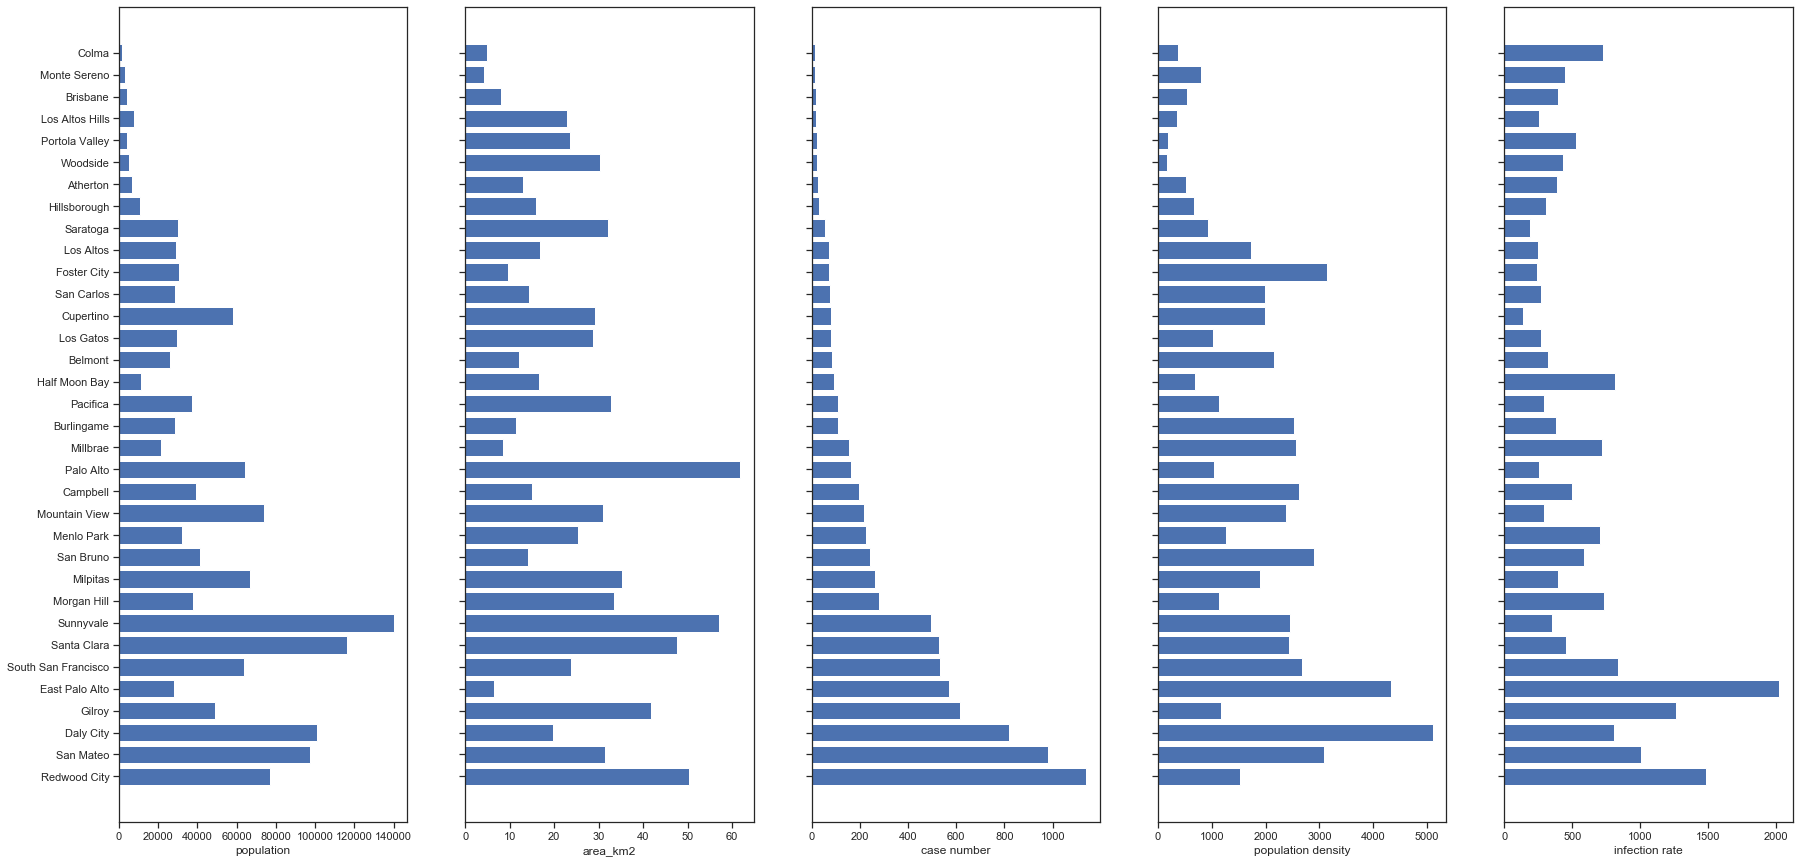

In [424]:
fig, ax = plt.subplots(1, 5, figsize=(30, 15), sharey=True)
ax[0].barh(new_city['name'],new_city['population'])
ax[0].set(xlabel='population')
ax[1].barh(new_city['name'],new_city['area_km2'])
ax[1].set(xlabel='area_km2')
ax[2].barh(new_city['name'],new_city['case_num'])
ax[2].set(xlabel='case number')
ax[3].barh(new_city['name'],new_city['density'])
ax[3].set(xlabel='population density')
ax[4].barh(new_city['name'],new_city['infection_rate'])
ax[4].set(xlabel='infection rate')

The infection rate is the ratio of case nubmer to population multiplied by 100K. It can be used an indicator of level of infection risk. From the bar chart above, it appears to have some correlation with population density. Therefore, we plot the scatter plot of infection rate and population density. 

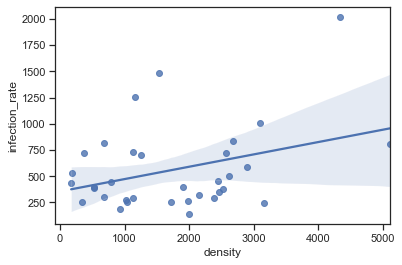

In [425]:
import seaborn as sns
sns.regplot(x='density',y='infection_rate', data=new_city)

In [426]:
ba_data.fillna(0,inplace=True)
ba_data.to_csv('bay city venue.csv')

#### We then compare the covid-19 case data with the social venues features

[Text(0.5, 0, 'residence')]

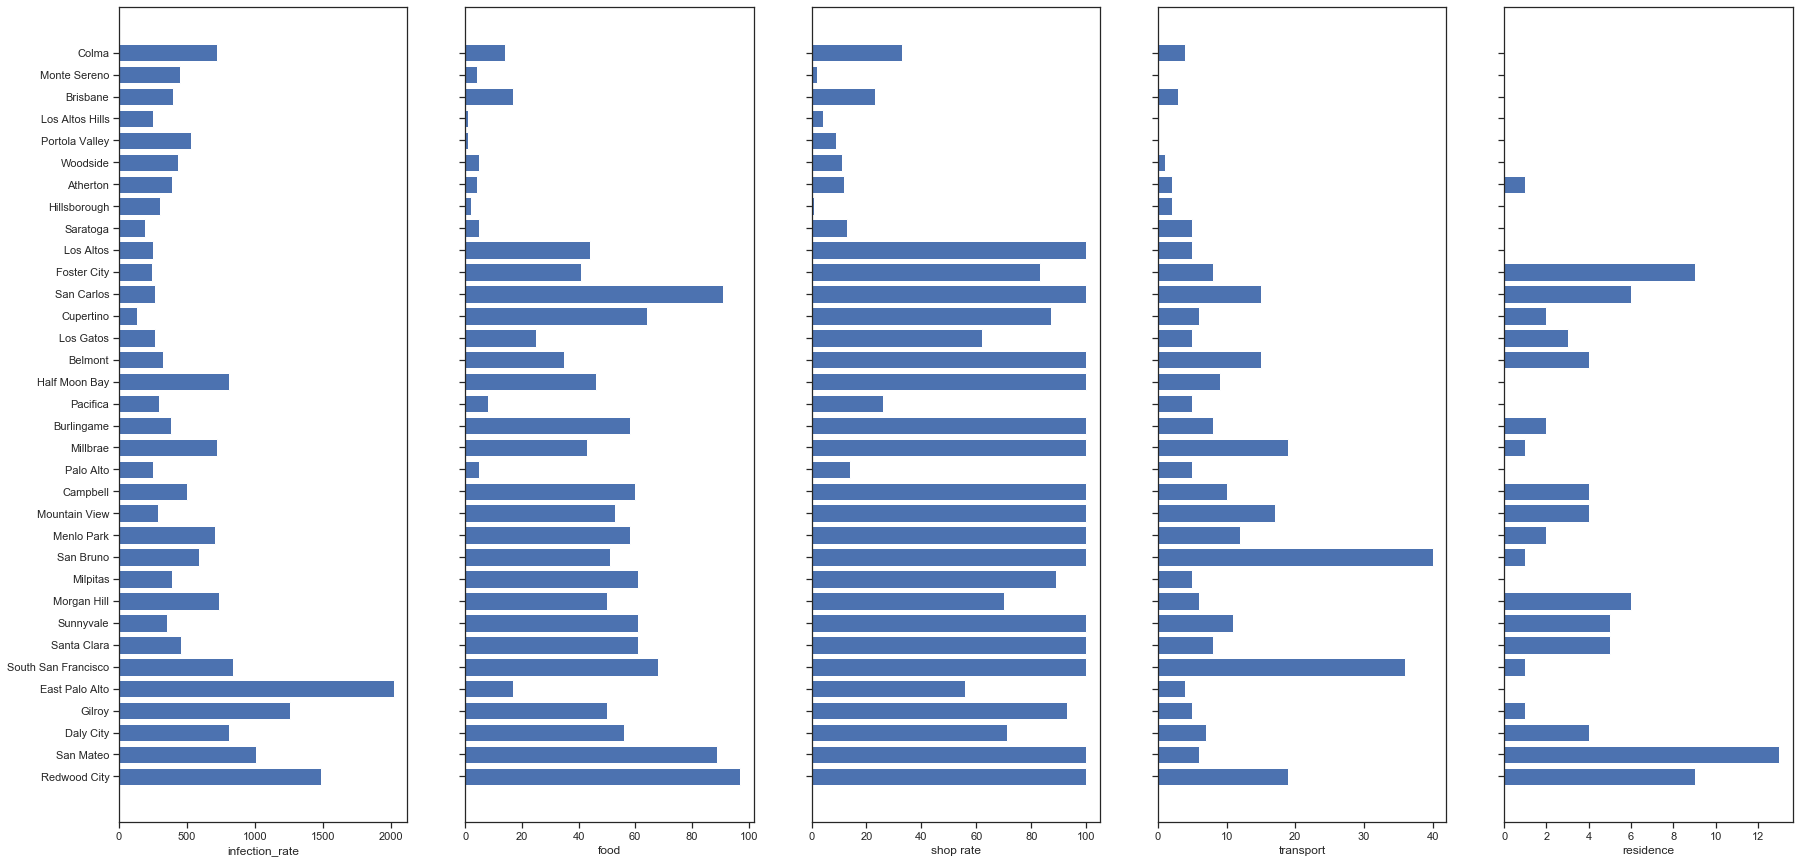

In [427]:
fig, ax = plt.subplots(1, 5, figsize=(30, 15), sharey=True)
ax[0].barh(ba_data['name'],ba_data['infection_rate'])
ax[0].set(xlabel='infection_rate')
ax[1].barh(ba_data['name'],ba_data['food'])
ax[1].set(xlabel='food')
ax[2].barh(ba_data['name'],ba_data['shop'])
ax[2].set(xlabel='shop rate')
ax[3].barh(ba_data['name'],ba_data['transport'])
ax[3].set(xlabel='transport')
ax[4].barh(ba_data['name'],ba_data['residence'])
ax[4].set(xlabel='residence')

Text(0, 0.5, 'infection_rate')

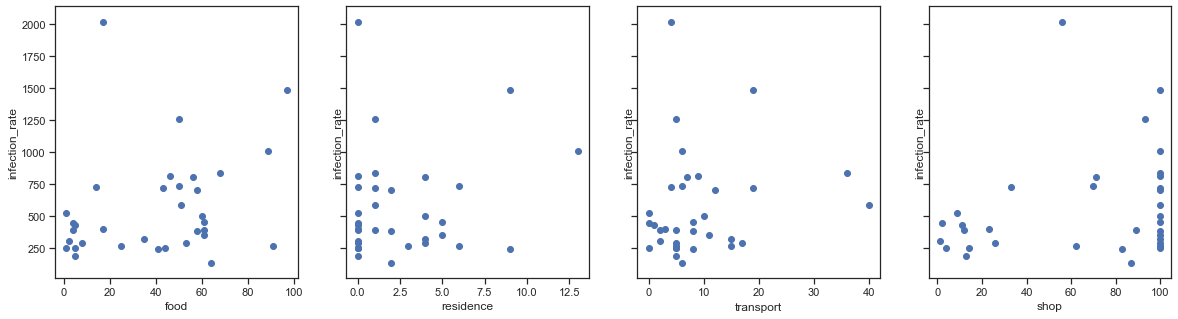

In [428]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
ax[0].scatter(ba_data['food'],ba_data['infection_rate'])
ax[0].set_xlabel('food')
ax[0].set_ylabel('infection_rate')

ax[1].scatter(ba_data['residence'],ba_data['infection_rate'])
ax[1].set_xlabel('residence')
ax[1].set_ylabel('infection_rate')

ax[2].scatter(ba_data['transport'],ba_data['infection_rate'])
ax[2].set_xlabel('transport')
ax[2].set_ylabel('infection_rate')

ax[3].scatter(ba_data['shop'],ba_data['infection_rate'])
ax[3].set_xlabel('shop')
ax[3].set_ylabel('infection_rate')

From the plots above, we can see a corresponding increase in infection rate from food venues. We also observe a similar relation in the number of shop venues. It is noted that the infection rate varies largely when the number of shop venues is 100 which is due to the limit of Foursquare API is 100 per request. For residence and transport venues, the dependence is not so evident because of the impact from outliers. Therefore, we decide to use number of shops and food venues as the primary geolocation characteristics correlated with infection rate. 

#### Clustering cities

Feature extraction

In [429]:
ba_2bgrouped=ba_data.drop(['name','type','county','area_km2','lat','lng','population','case_num','residence','transport'],axis=1)
ba_2bgrouped.head()

,infection_rate,density,food,shop
0,1484.085140,1527.137177,97.0,100.0
1,1008.157849,3095.764331,89.0,100.0
2,807.926980,5107.222222,56.0,71.0
3,1259.703816,1167.966507,50.0,93.0
4,2020.955425,4331.538462,17.0,56.0


Normalizing data

In [430]:
from sklearn.preprocessing import StandardScaler
X = ba_2bgrouped.values[:,0:4]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 2.33385241, -0.19323838,  2.05577922,  0.86746894],
       [ 1.13116891,  1.16033176,  1.76946486,  0.86746894],
       [ 0.62517909,  2.89602104,  0.58841812,  0.11784197],
       [ 1.76683362, -0.50316716,  0.37368235,  0.6865245 ],
       [ 3.69054082,  2.22668265, -0.8073644 , -0.26989612],
       [ 0.70023671,  0.80579173,  1.01788966,  0.86746894],
       [-0.2665255 ,  0.59591919,  0.76736459,  0.86746894],
       [-0.52531256,  0.60962573,  0.76736459,  0.86746894],
       [ 0.43800382, -0.53231155,  0.37368235,  0.09199276],
       [-0.42518856,  0.12629909,  0.76736459,  0.58312767],
       [ 0.0648048 ,  0.98739583,  0.40947164,  0.86746894],
       [ 0.3667892 , -0.42300396,  0.65999671,  0.86746894],
       [-0.67951539,  0.54402972,  0.48105023,  0.86746894],
       [-0.15132461,  0.75261299,  0.7315753 ,  0.86746894],
       [-0.77297834, -0.61176047, -1.23683594, -1.35556276],
       [ 0.40262802,  0.70089645,  0.12315728,  0.86746894],
       [-0.45149345,  0.

In [431]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[1 2 0 1 0 2 2 2 1 2 2 1 2 2 1 2 2 1 1 2 1 2 2 2 2 1 1 1 1 1 1 1 1 1]


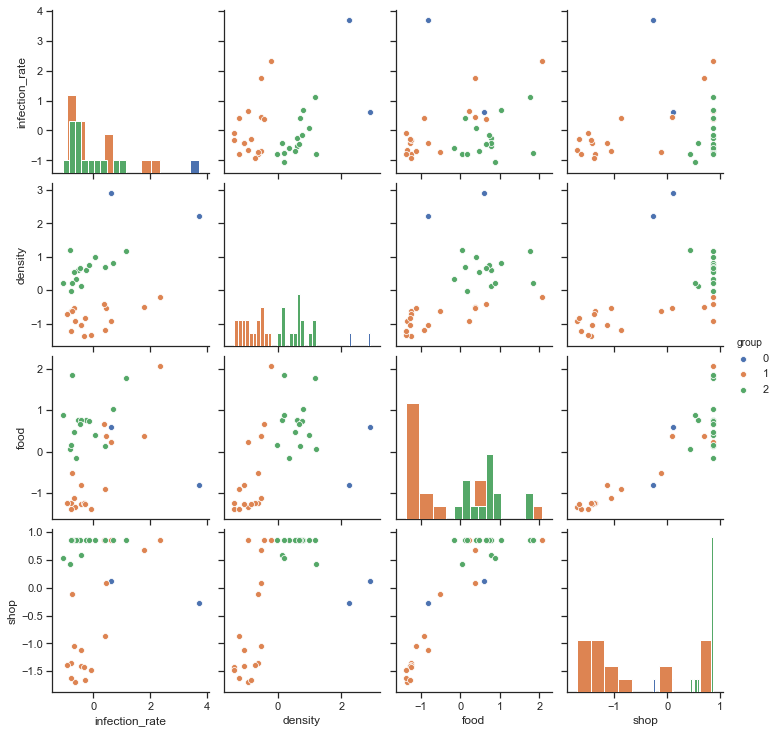

In [432]:
df2 = pd.DataFrame(np.array(Clus_dataSet), columns=['infection_rate', 'density', 'food', 'shop'])
df2['group']=labels
sns.set(style="ticks")
sns.pairplot(df2,hue='group',diag_kind="hist")

## Results and Discussion <a name="results"></a>

Based on the pair scatter plots above, there is clear difference between cities with high infection rates and population density, i.e. group 2, and cities in other groups. Especially, East Palo Alto in group 2 is clearly an outlier in those infection rate plots. Furthermore, we note that group 2 is distinct from the other two groups when looking into the relation between population density and the number of venues. For example, for the same number of food and shop venues, those two cities are more populated, indicating that the residents are underserved and additional travel are needed to obtain the necessity of life.  Therefore, we conclude that group 2 has the highest infection risk given that other factors in this studies are the same. 

For group 1 and group 0, the difference is not so evident as compared to group 2. But the infection rate is higher for group 1 than group 0 at the same population density, number of shops or number of food venues. So it is valid to expect that infection risk in group 1 is higher than group 0. 

In summary, cities in group 2, group 1, group 0 are ranked by infection risk from high to low based on our analysis. 

In [433]:
ba_data['labels']=labels
ba_data.sort_values(['infection_rate'], ascending=False, axis=0, inplace=True)
ba_data.reset_index(drop=True, inplace=True)
ba_data

,name,type,county,population,area_km2,lat,lng,case_num,infection_rate,density,food,residence,shop,transport,labels
0,East Palo Alto,City,San Mateo,28155,6.5,37.468827,-122.141075,569,2020.955425,4331.538462,17.0,0.0,56.0,4.0,0
1,Redwood City,City,San Mateo,76815,50.3,37.485215,-122.236355,1140,1484.085140,1527.137177,97.0,9.0,100.0,19.0,1
2,Gilroy,City,Santa Clara,48821,41.8,37.002983,-121.556637,615,1259.703816,1167.966507,50.0,1.0,93.0,5.0,1
3,San Mateo,City,San Mateo,97207,31.4,37.562992,-122.325525,980,1008.157849,3095.764331,89.0,13.0,100.0,6.0,2
4,South San Francisco,City,San Mateo,63632,23.7,37.654656,-122.407750,533,837.628866,2684.894515,68.0,1.0,100.0,36.0,2
5,Half Moon Bay,City,San Mateo,11324,16.6,37.463552,-122.428586,92,812.433769,682.168675,46.0,0.0,100.0,9.0,1
6,Daly City,City,San Mateo,101123,19.8,37.687924,-122.470208,817,807.926980,5107.222222,56.0,4.0,71.0,7.0,0
7,Morgan Hill,City,Santa Clara,37882,33.4,37.130501,-121.654390,278,733.857769,1134.191617,50.0,6.0,70.0,6.0,1
8,Colma,Town,San Mateo,1792,4.9,37.674904,-122.456153,13,725.446429,365.714286,14.0,0.0,33.0,4.0,1
9,Millbrae,City,San Mateo,21532,8.4,37.598547,-122.387194,155,719.858815,2563.333333,43.0,1.0,100.0,19.0,2


Finally, we **cluster** those cities/towns to create a map where the risk ranking are colored by red, orange and blue, respectively. 

In [436]:
# create map
latitude=ba_data.loc[0,'lat']
longitude=ba_data.loc[0,'lng']
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
#x = np.arange(clusterNum)
#ys = [i + x + (i*x)**2 for i in range(clusterNum)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [ 'yellow','green', 'red']


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ba_data['lat'], ba_data['lng'], ba_data['name'], ba_data['labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Conclusion <a name="conclusion"></a>

The purpose of this project was to study the relation between geolocation data and Covid-19 infection data. We obtained geolocation data of 34 cities and towns in the Peninsular and South Bay from Google Map and Foursquare, and Covid-19 case data from San Francisco Chronicle. By exploring the data with visualization method and K-means clustering modeling, we identified three groups with different infection risk level. The final results are presented in a map. 

This report is a preliminary study to demonstrate exploring geolocation data and other data source to gain insights about the Covid-19 infection cases. Due to the limited time and resource, other important factors such as migration of population, access to healthcare and social economics status are not considered in this project. It is important to consider those factors to gain a bigger picture in order to address the challenges posed by the Covid-19 pandemic. 